In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, recall_score, precision_score
import numpy as np

In [7]:
def calculate_score_delta_t(data_frame, score_type, no_sensors, start_time, max_delta, step_size):
    """
    :param data_frame: Complete Dataframe
    :param no_sensors: Number of Sensors in Dataframe
    :param start_time: Start point. Value from time column
    :param max_delta: Number of samples. max_time = (no_samples * (time between two samples))
    :param step_size: It is the number of samples added to current time_delta to get next time_delta
    :return:
    """
    global column_names
    index_start = data_frame.index[data_frame['ID'] == float(start_time)].to_list()[0]
    subset = data_frame.loc[index_start:(index_start + max_delta), :]
    labels_pred = subset.iloc[:, (4 * no_sensors) + 2:(5 * no_sensors) + 2]
    labels_true = subset.iloc[:, (5 * no_sensors) + 2]

    number_evalutation_sequences = round(max_delta / step_size)
    result_score = np.zeros((number_evalutation_sequences, no_sensors + 1))

    for sensor in range(no_sensors):
        for iteration in range(1, number_evalutation_sequences - 1):
            anomaly_true = labels_true.iloc[0: (iteration * step_size)].values
            anomaly_pred = labels_pred.iloc[0: (iteration * step_size), sensor].values
            if score_type == "true_positive_rate":
                TP = confusion_matrix(anomaly_true, anomaly_pred)[1][1]
                FN = confusion_matrix(anomaly_true, anomaly_pred)[1][0]
                result = TP / (TP + FN)
                column_names = ["TPR_Sensor_" + str(i) for i in range(no_sensors)]
            else:
                result = 0
                column_names = ["error" for i in range(no_sensors)]

            result_score[iteration - 1, sensor] = result
            result_score[iteration - 1, no_sensors] = iteration * step_size

    score_df = pd.DataFrame(data=result_score, columns=column_names + ["delta_t"])
    return score_df

In [8]:
def calculate_score(data_frame, score_type, no_sensors):
    """
    :param data_frame: Complete Dataframe
    :param no_sensors: Number of Sensors in Dataframe
    :param start_time: Start point. Value from time column
    :param max_delta: Number of samples. max_time = (no_samples * (time between two samples))
    :param step_size: It is the number of samples added to current time_delta to get next time_delta
    :return:
    """
    labels_pred = data_frame.iloc[:, (4 * no_sensors) + 2:(5 * no_sensors) + 2]
    labels_true = data_frame.iloc[:, (5 * no_sensors) + 2].values
    
    result_score = np.zeros((no_sensors))

    for sensor in range(no_sensors):
        anomaly_pred = labels_pred.iloc[:, sensor].values
        if score_type == "f1_score":
            result = f1_score(labels_true, anomaly_pred, average="binary")
            index_names = ["f1 sensor_" + str(i) for i in range(no_sensors)]
        elif score_type == "precision_score":
            result = precision_score(labels_true, anomaly_pred, average="binary")
            index_names = ["precision sensor_" + str(i) for i in range(no_sensors)]
        elif score_type == "recall_score":
            result = recall_score(labels_true, anomaly_pred, average="binary")
            index_names = ["recall sensor_" + str(i) for i in range(no_sensors)]
        else:
            result = 0
            index_names = ["error" for i in range(no_sensors)]
            
        result_score[sensor] = result

    score_df = pd.Series(data=result_score, index=index_names)
    return score_df

In [9]:
def visualise_metric_per_sensor(results, title):
    fig, axes = plt.subplots(results.shape[1]-1, 1, figsize=(10,20),constrained_layout=False)
    ax = axes.ravel()
    t = results.loc[:,"delta_t"]
    columns = results.columns
    for i in range(results.shape[1]-1): 
        sns.lineplot(data=results, 
                     x=t, 
                     y=columns[i], 
                     ax=ax[i],
                     linewidth=1,
                     color="black")
        ax[i].set_xlabel("delta t [in samples]")
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle(title, fontsize=16)

In [22]:
def visualise_metric_machine(results, score_type, phase):
    t = results.loc[:,"delta_t"]
    complete_title = "CPPS Data - Beginning of Phase '{}''".format(phase)
    
    # Caluculate Metric for hole machine (sum over sensors and devide by no_sensors)
    labels = results.drop(columns="delta_t", axis=0)
    result_machine = labels.sum(axis=1) / results.shape[1]
    
    # Visualise Results
    sns.lineplot(x=t, 
                 y=result_machine, 
                 linewidth=1,
                 color="black")
    plt.xlabel("delta t [in samples]")
    plt.ylabel("{} over all dim".format(score_type))
    #plt.tight_layout()
    plt.title(complete_title, fontsize=16, y=1.12)

In [11]:
def vis_cumulative_detection(dataframe, no_features, first_feature, last_feature, location_line1, location_line2):
    fig, axes = plt.subplots(no_features, 1, figsize=(30,40))
    ax = axes.ravel()
    columns = dataframe.columns
    t = dataframe.iloc[:,0]
    for i in range(first_feature, last_feature):
        sns.lineplot(data=dataframe, 
                     x=t, 
                     y=dataframe.iloc[:, i+4*no_features+1].cumsum(),
                     ax=ax[i-first_feature],
                     color="blue",)
        ax[i-first_feature].set_ylim(0, 5000) 
        ax[i-first_feature].axvline(location_line1, color="r", linestyle ="--", linewidth=1)
        ax[i-first_feature].axvline(location_line2, color="r", linestyle ="--", linewidth=1)
        ax[i-first_feature].text(10000, 4000, "Phase 0: No Error", fontsize=15)
        ax[i-first_feature].text(27000, 4000, "Phase 1: Small Error", fontsize=15)
        ax[i-first_feature].text(40000, 4000, "Phase 2: Large Error", fontsize=15)

# Evaluation of Prediction Interval Metric
## Setup

In [12]:
start_phase_1 = 24683.0
start_phase_2 = 38966.0

In [13]:
all_data = pd.read_csv("../../files/prediction/MLE/cpps_new_2sigma.csv", sep=";")
phase_0 = all_data.loc[all_data["ID"]<=start_phase_1]
phase_1 = all_data.loc[all_data["ID"]>=start_phase_1]
phase_2 = all_data.loc[all_data["ID"]>=start_phase_2]
phase_0_and_1 = all_data.loc[all_data["ID"]<start_phase_2]
phase_0_and_2 = pd.concat([phase_0, phase_2], ignore_index=True)

In [44]:
phase_0_and_2.head()

,ID,sensor_2 target,sensor_3 target,sensor_4 target,sensor_5 target,sensor_6 target,sensor_7 target,sensor_8 target,sensor_9 target,sensor_10 target,...,Anomaly Sensor_2,Anomaly Sensor_3,Anomaly Sensor_4,Anomaly Sensor_5,Anomaly Sensor_6,Anomaly Sensor_7,Anomaly Sensor_8,Anomaly Sensor_9,Anomaly Sensor_10,status
0,101.0,1.050311,-0.288966,2.622169,0.629691,0.535125,1.007001,0.806292,0.385174,0.239332,...,0,0,0,0,0,0,0,0,0,0
1,102.0,0.855389,-0.674310,2.841940,0.695511,0.426513,0.928420,0.546533,-0.049421,0.198970,...,0,0,0,0,0,0,0,0,0,0
2,103.0,0.793249,-0.813778,2.819760,0.621487,0.297168,0.913767,0.448677,-0.116216,0.132105,...,0,0,0,0,0,0,0,0,0,0
3,104.0,0.637474,-0.629878,2.566342,0.770167,0.584095,0.727841,0.484710,-0.065061,0.211005,...,0,0,0,0,0,0,0,0,0,0
4,105.0,0.792423,-0.809434,2.800128,0.610295,0.289290,0.913107,0.449387,-0.101638,0.126802,...,0,0,0,0,0,0,0,0,0,0


# Model Evaluation - Phases
## Phase 0 + Phase 1
### F1 Score 

In [54]:
score = calculate_score(phase_0_and_1, "f1_score", 10)
print(score.sum()/10)

0.1750917151180948


### ROC-AUC Score

In [53]:
"""
score_result = calculate_score(phase_0_and_1, "roc_auc_score", 10)
print(score.sum()/10)
"""

0.1750917151180948


## Phase 0 + Phase 2
### F1 Score 

In [23]:
score = calculate_score(phase_0_and_2, "f1_score", 10)
print(score.sum()/10)

0.4912359148581955


### ROC-AUC Score

In [49]:
"""
score_result = calculate_score(phase_0_and_2, "roc_auc_score", 10)
print(score.sum()/10)
"""

f1 sensor_0    0.495578
f1 sensor_1    0.524419
f1 sensor_2    0.471366
f1 sensor_3    0.485411
f1 sensor_4    0.504577
f1 sensor_5    0.450248
f1 sensor_6    0.526130
f1 sensor_7    0.412032
f1 sensor_8    0.527896
f1 sensor_9    0.514701
dtype: float64


# Model Evaluation - Delta t
## Start Phase 1

In [17]:
delta_t_start_phase1 = calculate_score_delta_t(data_frame=all_data, 
                                               score_type="true_positive_rate", 
                                               no_sensors=10, 
                                               start_time=start_phase_1, 
                                               max_delta=500, 
                                               step_size=10)

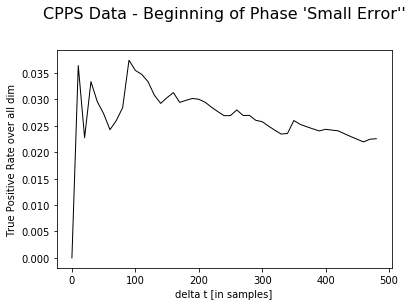

In [18]:
visualise_metric_machine(delta_t_start_phase1, "True Positive Rate", "Small Error")
#plt.savefig("./f1_score_cpps_data.png")
plt.show()

## Start Phase 2

In [20]:
delta_t_start_phase2 = calculate_score_delta_t(data_frame=all_data, 
                                               score_type="true_positive_rate", 
                                               no_sensors=10, 
                                               start_time=start_phase_2, 
                                               max_delta=500, 
                                               step_size=10)

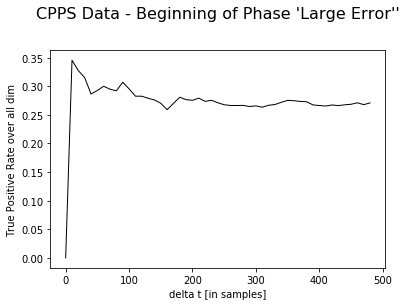

In [21]:
visualise_metric_machine(delta_t_start_phase2, "True Positive Rate", "Large Error")
#plt.savefig("./f1_score_cpps_data.png")
plt.show()

# Cumulative Sum of Anomaly, labeld by LSTM-Model

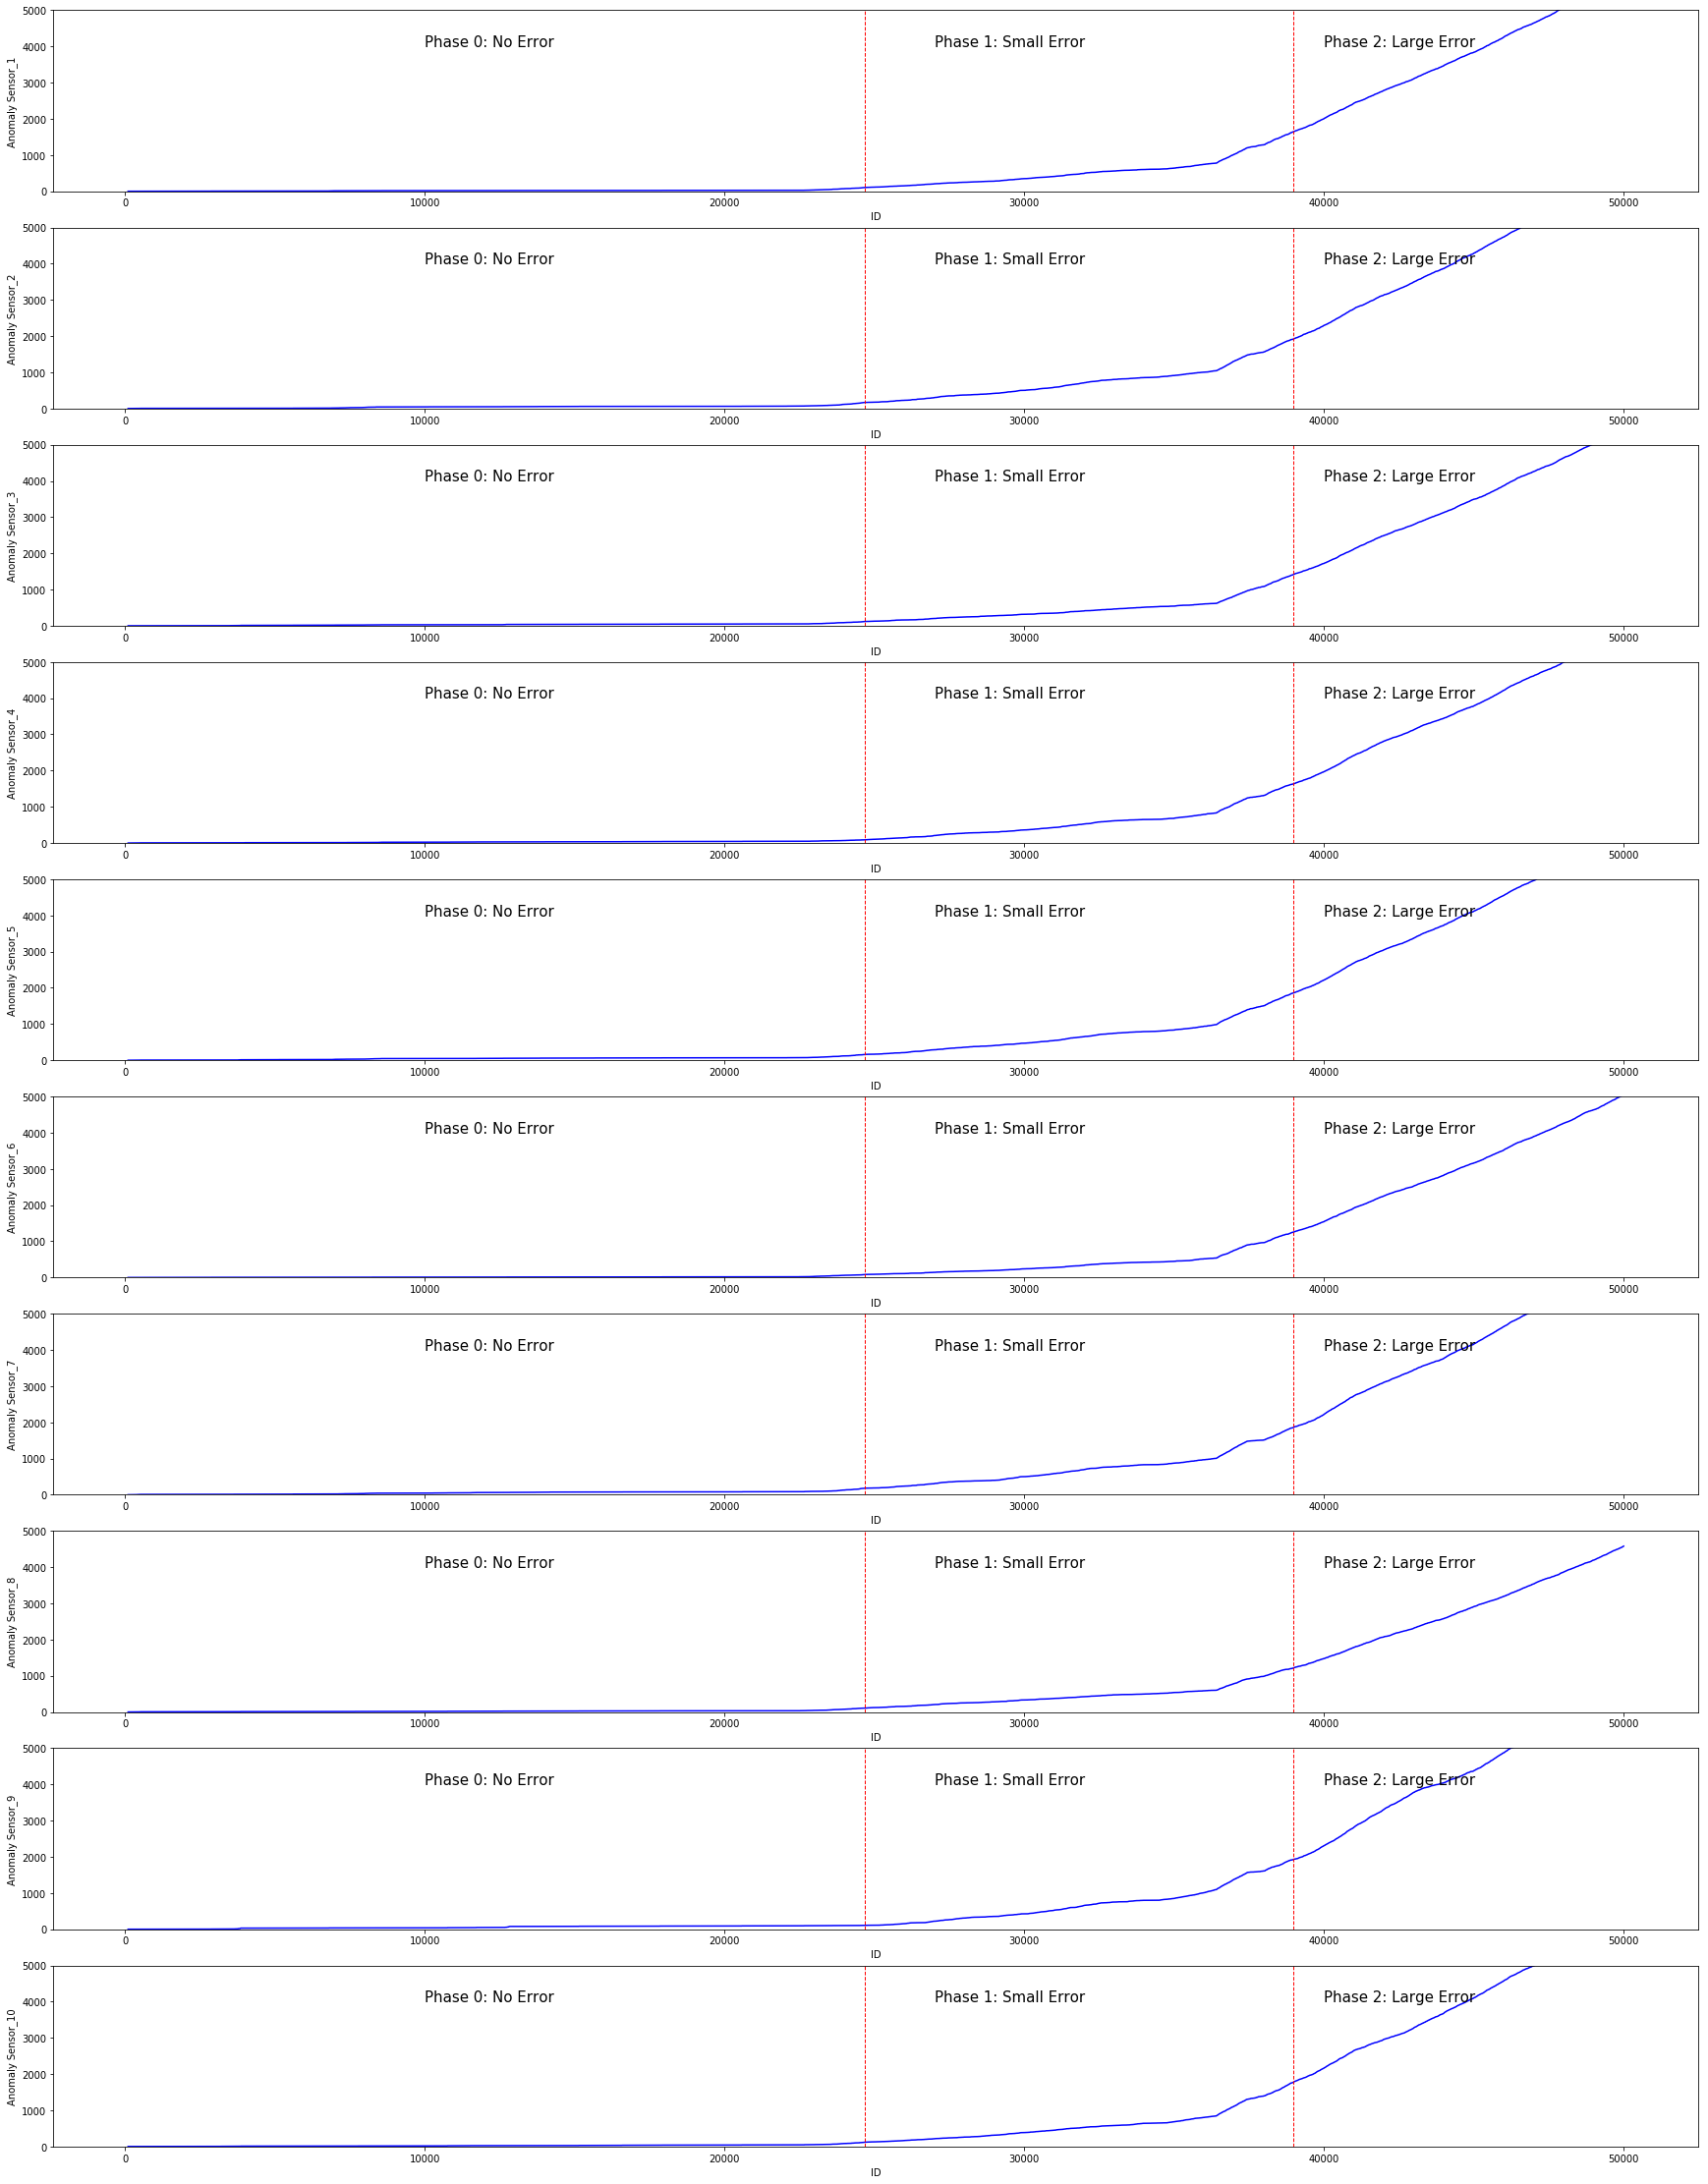

In [5]:
vis_cumulative_detection(all_data, 10, 1, 11, start_phase_1, start_phase_2)
plt.show()